# Evasion Attacks on ImageNet (Advanced)

We show here how to run different evasion attacks against ResNet-18, 
a DNN pretrained on ImageNet. This notebook enables running also 
CleverHans attacks (implemented in TensorFlow) against PyTorch models.

We aim to have the image of a race car misclassified as a tiger, 
using the $\ell_2$-norm targeted implementations of the Carlini-Wagner (CW) 
attack (from CleverHans), and of our PGD attack. 

We also consider a variant of our PGD attack, referred to as PGD-patch, 
where we restrict the attacker to only change the pixels of the image 
corresponding to the license plate, using a box constraint (see Melis et al., 
*Is Deep Learning Safe for Robot Vision? Adversarial Examples against the iCub Humanoid*, 
ICCVW ViPAR 2017, https://arxiv.org/abs/1708.06939).

## Load data
We start by loading the pre-trained ResNet18 model from `torchvision`, 
and we pass it to the `SecML` wrapper.  Then, we load the ImageNet labels.

In [1]:
# NBVAL_IGNORE_OUTPUT
from torchvision import models

# Download and cache pretrained model from PyTorch model zoo
model = models.resnet18(pretrained=True)

In [2]:
import io

import numpy as np
import requests
import torch

from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMeanStd

# Set random seed for pytorch and numpy
np.random.seed(0)
torch.manual_seed(0)

# imagenet normalization
normalizer = CNormalizerMeanStd(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))

# wrap the model, including the normalizer
clf = CClassifierPyTorch(model=model,
                         input_shape=(3, 224, 224),
                         softmax_outputs=False,
                         preprocess=normalizer,
                         random_state=0)

# load the imagenet labels
import json

imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r.text))

We load the image of a race car that we would like to have misclassified 
as a tiger and we show it, along with the classifier prediction.

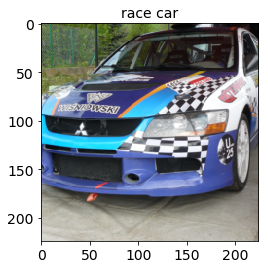

In [3]:
import numpy as np
from PIL import Image
from torchvision import transforms

from secml.array import CArray

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),         
])

img_path = "https://images.pexels.com/photos/589782/pexels-photo-589782.jpeg"\
            "?cs=srgb&dl=car-mitshubishi-race-rally-589782.jpg&fm=jpg"
r = requests.get(img_path)
img = Image.open(io.BytesIO(r.content))

# apply transform from torchvision
img = transform(img)
# transform the image into a vector
img = torch.unsqueeze(img, 0).view(-1)
img = CArray(img.numpy())

# get the classifier prediction
preds = clf.predict(img)
pred_class = preds.item()
pred_label = labels[pred_class]

# create a function to show images
def plot_img(f, x, label):
    x = np.transpose(x.tondarray().reshape((3, 224, 224)), (1, 2, 0))
    f.sp.title(label)
    f.sp.imshow(x)
    return f 
    
# show the original image
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(height=4, width=4, fontsize=14)
plot_img(fig, img, label=pred_label)
fig.show()

## Run the attack

We should create the attack class that we will use to compute the attack.
Changing the value of the variable `attack_type`, you can choose between 
three different attacks: `CW`, `PGD`, and `PGD-patch`.

Note that the PGD-patch attack may take some time to run depending on the machine.

In [4]:
attack_type = 'PGD-patch'
# attack_type = 'PGD'
# attack_type = 'CW'

To perform a `PGD-patch` attack that only manipulates the license plate in 
our car image, we need to define a proper box constraint along with its 
upper and lower bounds. To this end, we create the following function:

In [5]:
def define_lb_ub(image, x_low_b, x_up_b, y_low_b, y_up_b, low_b, up_b, n_channels=3):
    
    # reshape the img (it is stored as a flat vector)
    image = image.tondarray().reshape((3, 224, 224))

    # assign to the lower and upper bound the same values of the image pixels
    low_b_patch = deepcopy(image)
    up_b_patch = deepcopy(image)

    # for each image channel, set the lower bound of the pixels in the 
    # region defined by x_low_b, x_up_b, y_low_b, y_up_b equal to lb and 
    # the upper  bound equal to up in this way the attacker will be able 
    # to modify only the pixels in this region.
    for ch in range(n_channels):
         low_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = low_b
         up_b_patch[ch, x_low_b:x_up_b, y_low_b:y_up_b] = up_b

    return CArray(np.ravel(low_b_patch)), CArray(np.ravel(up_b_patch))

We instantiate and run the attack, and show the resulting adversarial 
image along with its explanations, computed via integrated gradients.

In [6]:
from copy import deepcopy

from cleverhans.attacks import CarliniWagnerL2

from secml.adv.attacks import CAttackEvasion
from secml.data import CDataset
from secml.explanation import CExplainerIntegratedGradients

lb = 0 
ub = 1
target_idx = 292  # tiger 

attack_id = ''
attack_params = {}

if attack_type == "CW":
    attack_id = 'e-cleverhans'
    attack_params = {'max_iterations': 50, 'learning_rate': 0.005, 
                     'binary_search_steps': 1, 'confidence': 1e6,
                     'abort_early': False, 'initial_const': 0.4,
                     'n_feats': 150528, 'n_classes': 1000,
                     'y_target': target_idx,
                     'clip_min': lb, 'clip_max': ub,
                     'clvh_attack_class': CarliniWagnerL2}
    
if attack_type == 'PGD':
    attack_id = 'e-pgd'
    solver_params = {
        'eta': 1e-2, 
        'max_iter': 50,
        'eps': 1e-6}
    attack_params = {'distance': 'l2',
                     'dmax': 1.875227,
                     'lb': lb,
                     'ub': ub,
                     'y_target': target_idx,
                     'solver_params': solver_params}

if attack_type == 'PGD-patch':
    attack_id = 'e-pgd'
    # create the mask that we will use to allows the attack to modify only 
    # a restricted region of the image
    x_lb = 140; x_ub = 160; y_lb = 10; y_ub = 80
    dmax_patch = 5000    
    lb_patch, ub_patch = define_lb_ub(
        img, x_lb, x_ub, y_lb, y_ub, lb,ub, n_channels=3)
    solver_params = {
        'eta': 0.8,
        'max_iter': 50,
        'eps': 1e-6}

    attack_params = {'distance': 'l2',
                     'dmax': dmax_patch,
                     'lb': lb_patch,
                     'ub': ub_patch,
                     'y_target': target_idx,
                     'solver_params': solver_params}
    
val = CDataset(img, pred_class)

attack = CAttackEvasion.create(
    attack_id, 
    clf, 
    surrogate_classifier=clf,
    surrogate_data=val,
    **attack_params)

# run the attack
eva_y_pred, _, eva_adv_ds, _ = attack.run(img, pred_class)
adv_img = eva_adv_ds.X[0,:]

# get the classifier prediction
advx_pred = clf.predict(adv_img)
advx_label_idx = advx_pred.item()
adv_pred_label = labels[advx_label_idx]

We compute the explanations for the adversarial image with respect to the 
target class and visualize the attack results. See the [Explainable Machine Learning](
10-Explanation.ipynb) tutorial for more information.

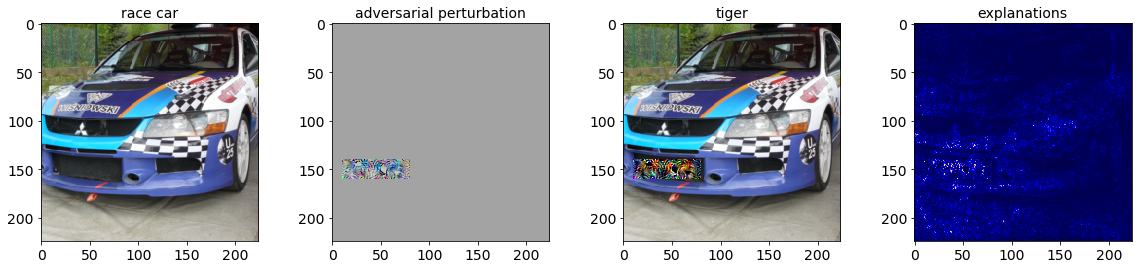

In [7]:
# compute the explanations w.r.t. the target class
explainer = CExplainerIntegratedGradients(clf)
expl = explainer.explain(adv_img, y=target_idx, m=500)

fig = CFigure(height=4, width=20, fontsize=14)

fig.subplot(1, 4, 1)
# plot the original image
fig = plot_img(fig, img, label=pred_label)

# compute the adversarial perturbation 
adv_noise =  adv_img - img

# normalize perturbation for visualization
diff_img = img - adv_img
diff_img -= diff_img.min()
diff_img /= diff_img.max()

# plot the adversarial perturbation
fig.subplot(1, 4, 2)
fig = plot_img(fig, diff_img, label='adversarial perturbation')

fig.subplot(1, 4, 3) 
# plot the adversarial image
fig = plot_img(fig, adv_img, label=adv_pred_label)

fig.subplot(1, 4, 4)

expl = np.transpose(expl.tondarray().reshape((3, 224, 224)), (1, 2, 0))
r = np.fabs(expl[:, :, 0])
g = np.fabs(expl[:, :, 1])
b = np.fabs(expl[:, :, 2])

# Calculate the maximum error for each pixel
expl = np.maximum(np.maximum(r, g), b)
fig.sp.title('explanations')
fig.sp.imshow(expl, cmap='seismic')

fig.show()

## Visualize and check the attack optimization

To check if the attack has properly converged to a good local minimum, 
we plot how the loss and the predicted confidence values of the target 
(solid line) and true class (dotted line) change across the attack iterations.

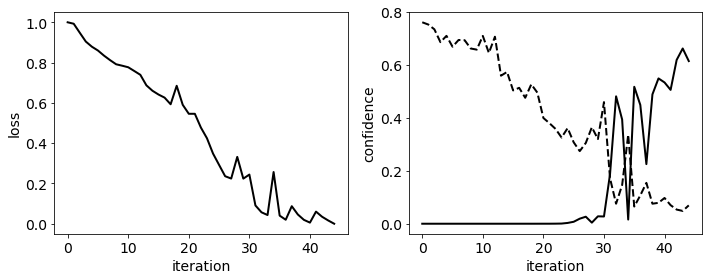

In [8]:
from secml.ml.classifiers.loss import CSoftmax
from secml.ml.features.normalization import CNormalizerMinMax

n_iter = attack.x_seq.shape[0]
itrs = CArray.arange(n_iter)

# create a plot that shows the loss and the confidence during the attack iterations
# note that the loss is not available for all attacks
fig = CFigure(width=10, height=4, fontsize=14, linewidth=2)

# apply a linear scaling to have the loss in [0,1]
loss = attack.f_seq
if loss is not None:
    loss = CNormalizerMinMax().fit_transform(CArray(loss).T).ravel()
    fig.subplot(1, 2, 1)
    fig.sp.xlabel('iteration')
    fig.sp.ylabel('loss')
    fig.sp.plot(itrs, loss, c='black')

# classify all the points in the attack path
scores = clf.predict(attack.x_seq, return_decision_function=True)[1]

# we apply the softmax to the score to have value in [0,1]
scores = CSoftmax().softmax(scores)

fig.subplot(1, 2, 2)
fig.sp.xlabel('iteration')
fig.sp.ylabel('confidence')
fig.sp.plot(itrs, scores[:, pred_class], linestyle='--', c='black')
fig.sp.plot(itrs, scores[:, target_idx], c='black')

fig.tight_layout()
fig.show()